In [1]:
#@title Font Install for plots
# !sudo ACCEPT_EULA=Y apt -y install msttcorefonts -qq
# !rm ~/.cache/matplotlib -rf

### Optimization of Elastic constants for DFT lattice constant

In [2]:
#@title Imports and utility code
!pip install -q uv
!uv pip install -q --system git+https://www.github.com/google/jax-md

import jax.numpy as jnp
import numpy as onp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacfwd
from jax import random
from jax import lax
from functools import wraps, partial
from jax import config
config.update('jax_enable_x64', True)
from jax import hessian
from jax_md import space
from jax_md import minimize
from jax_md import simulate
from jax_md import energy
from jax_md import partition
from jax_md import elasticity
from jax_md import quantity, util, smap
from jax_md.util import f32, f64
from jax.scipy.optimize import minimize as jax_min
from scipy.optimize import minimize as scipy_min

import time
from typing import Callable, Tuple, TextIO, Dict, Any, Optional
from functools import partial
import pandas as pd

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc({'text.usetex' : False,
                     'font.size': 14,
                     'font.family': 'Arial',
                     # 'mathtext.fontset': 'cm',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': 'Arial',
                     'mathtext.it': 'Arial:italic',
                     'mathtext.bf': 'Arial:bold',
                    })

def lattice(R_unit_cell, copies, lattice_vectors):
  """Repeats a unit cell along lattice vectors. """
  lattice_vectors = onp.array(lattice_vectors, f64)

  N, d = R_unit_cell.shape
  if isinstance(copies, int):
    copies = (copies,) * d

  if lattice_vectors.ndim == 0 or lattice_vectors.ndim == 1:
    cartesian = True
    L = onp.eye(d) * lattice_vectors[onp.newaxis, ...]
  elif lattice_vectors.ndim == 2:
    assert lattice_vectors.shape[0] == lattice_vectors.shape[1]
    cartesian = False
    L = onp.eye(d) / onp.array(copies)[onp.newaxis, ...]
    R_unit_cell /= onp.array(copies)[onp.newaxis, ...]
  else:
    raise ValueError()

  Rs = []
  for indices in onp.ndindex(copies):
    dR = 0.
    for idx, i in enumerate(indices):
      dR += i * L[idx]
    R = R_unit_cell + dR[onp.newaxis, :]
    Rs += [R]

  return onp.concatenate(Rs)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 86.8 MB/s eta 0:00:00


## Si Unit cell

In [3]:
# Silicon Conventional cell
si_text_con = """0.250000 0.750000 0.250000 Si
0.000000 0.000000 0.500000 Si
0.250000 0.250000 0.750000 Si
0.000000 0.500000 0.000000 Si
0.750000 0.750000 0.750000 Si
0.500000 0.000000 0.000000 Si
0.750000 0.250000 0.250000 Si
0.500000 0.500000 0.500000 Si"""

# Lattice constant for EDIP
latvec_con = jnp.array([[5.430, 0.000000, 0.000000], [0.00000, 5.430, 0.00000],[0.00000, 0.0000, 5.430]])
rows_con = si_text_con.split('\n')
rows_con = jnp.array([list(map(float,r.split(' ')[:3])) for r in rows_con])
R_con = lattice(rows_con, 2, latvec_con)
latvec_con *= 2.0
print("Number of atoms = {}".format(R_con.shape[0]))

Number of atoms = 64


In [4]:
# Setup the periodic boundary conditions.
displacement, shift = space.periodic_general(latvec_con)
dist_fun = space.metric(displacement)
neighbor_fn, energy_fn = energy.edip_neighbor_list(displacement, latvec_con)
exact_energy_fn = jit(energy.edip(displacement))
R = jnp.array(R_con, f64)
nbrs = neighbor_fn.allocate(R)

# Pressure convergence factor eV/A^3 to GPa
# http://greif.geo.berkeley.edu/~driver/conversions.html
P_con = 160.21766208

print('E (lammps) = {} eV'.format(-297.597013492761))
print('E_nl = {} eV'.format(energy_fn(R, neighbor=nbrs)))
print('E_exact = {} eV'.format(exact_energy_fn(R)))

print('Pressure with lammps (original units in bar) = {} GPa'.format(276.30824/10000))
print('Pressure with E_exact = {} GPa'.format(quantity.pressure(exact_energy_fn,R,latvec_con)*P_con))
print('Pressure with E_nl = {} GPa'.format(quantity.pressure(energy_fn,R,latvec_con,neighbor=nbrs)*P_con))

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


E (lammps) = -297.597013492761 eV
E_nl = -297.5970138794581 eV
E_exact = -297.597013879458 eV
Pressure with lammps (original units in bar) = 0.027630824000000002 GPa
Pressure with E_exact = 0.0276308055198951 GPa
Pressure with E_nl = 0.027630805519895097 GPa


## Elastic constants

In [5]:
emt_fn = jit(elasticity.athermal_moduli(energy_fn, check_convergence=True))
C_o, converged = emt_fn(R,latvec_con,neighbor=nbrs)
print(converged)
print(round(jit(elasticity.tensor_to_mandel)(C_o)*P_con, 4))

True
[[172.0389  64.6745  64.6745   0.       0.       0.    ]
 [ 64.6745 172.0389  64.6745   0.       0.       0.    ]
 [ 64.6745  64.6745 172.0389   0.       0.       0.    ]
 [  0.       0.       0.     145.5683   0.       0.    ]
 [  0.       0.       0.       0.     145.5683   0.    ]
 [  0.       0.       0.       0.       0.     145.5683]]


In [6]:
print('Bulk modulus with E_nl (athermal) = {} GPa'.format(elasticity.extract_isotropic_moduli(C_o)['B']*P_con))
print('Shear modulus with E_nl (athermal) = {} GPa'.format(elasticity.extract_isotropic_moduli(C_o)['G']*P_con))

Bulk modulus with E_nl (athermal) = 100.46260801410051 GPa
Shear modulus with E_nl (athermal) = 65.14337821735026 GPa


In [7]:
# VASP elastic constants
C_dft = jnp.array([[153.21414,56.79690,56.79690,0,0,0]
                   ,[56.79690,153.21414,56.79690,0,0,0]
                   ,[56.79690,56.79690,153.21414,0,0,0]
                   ,[0,0,0,149.66528,0,0]
                   ,[0,0,0,0,149.66528,0]
                   ,[0,0,0,0,0,149.66528]],dtype=f64)
print(round(C_dft,4))

[[153.2141  56.7969  56.7969   0.       0.       0.    ]
 [ 56.7969 153.2141  56.7969   0.       0.       0.    ]
 [ 56.7969  56.7969 153.2141   0.       0.       0.    ]
 [  0.       0.       0.     149.6653   0.       0.    ]
 [  0.       0.       0.       0.     149.6653   0.    ]
 [  0.       0.       0.       0.       0.     149.6653]]


## Initial conditions

In [8]:
# VASP relaxed lattice constant
# latvec_con = jnp.array([[5.4685816539983962, 0.00000000, 0.000000], [0.00000, 5.4685816539983962, 0.00000], [0.00000, 0.00000, 5.4685816539983962]])
latvec_con = jnp.array([[5.430, 0.000000, 0.000000], [0.00000, 5.430, 0.00000],[0.00000, 0.0000, 5.430]])
rows_con = si_text_con.split('\n')
rows_con = jnp.array([list(map(float,r.split(' ')[:3])) for r in rows_con])
R_con = lattice(rows_con, 2, latvec_con)
latvec_con *= 2.0
print("Number of atoms = {}".format(R_con.shape[0]))

# Setup the periodic boundary conditions.
displacement, shift = space.periodic_general(latvec_con)
dist_fun = space.metric(displacement)
neighbor_fn, energy_fn = energy.edip_neighbor_list(displacement, latvec_con)
exact_energy_fn = jit(energy.edip(displacement))
R = jnp.array(R_con, f64)
nbrs = neighbor_fn.allocate(R)

Number of atoms = 64


/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [9]:
# Original EDIP parameters
A_og1 = 7.9821730
lam_og1 = 1.4533108
params_og1 = jnp.array([A_og1,lam_og1],dtype=f64)

# Random parameters
onp.random.seed(1)
A_rand1 = 7.9821730 - onp.random.randint(-100,100)/60
lam_rand1 = 1.4533108 - onp.random.randint(-100,100)/200
params_rand1 = jnp.array([A_rand1,lam_rand1],dtype=f64)
print('A = {} , lambda = {}'.format(params_rand1[0], params_rand1[1]))

A = 9.032173 , lambda = 1.2533108


In [10]:
# Random parameters
onp.random.seed(4)
A_rand2 = 7.9821730 - onp.random.randint(-100,100)/60
lam_rand2 = 1.4533108 - onp.random.randint(-100,100)/200
params_rand2 = jnp.array([A_rand2,lam_rand2],dtype=f64)
print('A = {} , lambda = {}'.format(params_rand2[0], params_rand2[1]))

onp.random.seed(21)
A_rand3 = 7.9821730 - onp.random.randint(-100,100)/60
lam_rand3 = 1.4533108 - onp.random.randint(-100,100)/200
params_rand3 = jnp.array([A_rand3,lam_rand3],dtype=f64)
print('A = {} , lambda = {}'.format(params_rand3[0], params_rand3[1]))

A = 7.615506333333334 , lambda = 1.0833108
A = 8.715506333333334 , lambda = 1.9333107999999999


## Objective function

In [11]:
def setup(R, latvec):
  displacement, shift = space.periodic_general(latvec)
  dist_fun = space.metric(displacement)
  """
  Experimental C_{ij}
  C_e = jnp.array([[166,64,64,0,0,0]
                   ,[64,166,64,0,0,0]
                   ,[64,64,166,0,0,0]
                   ,[0,0,0,160,0,0]
                   ,[0,0,0,0,160,0]
                   ,[0,0,0,0,0,160]],dtype=f64)"""

  # DFT C_{ij}
  C_e = jnp.array([[153.21414,56.79690,56.79690,0,0,0],
                    [56.79690,153.21414,56.79690,0,0,0],
                    [56.79690,56.79690,153.21414,0,0,0],
                    [0,0,0,149.66528,0,0],
                    [0,0,0,0,149.66528,0],
                    [0,0,0,0,0,149.66528]],dtype=f64)
  def run(params):
    energy_fn = energy.edip(displacement,A=params[0],lam=params[1])
    emt_fn = elasticity.athermal_moduli(energy_fn)
    C = emt_fn(R, latvec)
    C_c = jit(elasticity.tensor_to_mandel)(C)*P_con
    return jnp.linalg.norm(C_c - C_e,ord='fro') # The Quantity to minimize
  return run

run = setup(R,latvec_con)

In [12]:
# jit the function
run_jit = jit(run)
grad_params = jit(jacfwd(run))

In [13]:
# Call the function
run_jit(params_og1)
grad_params(params_og1)

Array([31.9996089 , 20.30990911], dtype=float64)

#### Plotting Loss contour

In [14]:
# Calculate loss values over a grid
N = 40
A_search = jnp.linspace(5,10, N)
l_search = jnp.linspace(0.75,2.5, N)

Z_search = onp.zeros((N,N))
for i in range(len(A_search)):
  for j in range(len(l_search)):
    params_search = jnp.array([A_search[i],l_search[j]],dtype=f64)
    Z_search[i,j] = run_jit(params_search)

<ipython-input-15-a0c02226bab4>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


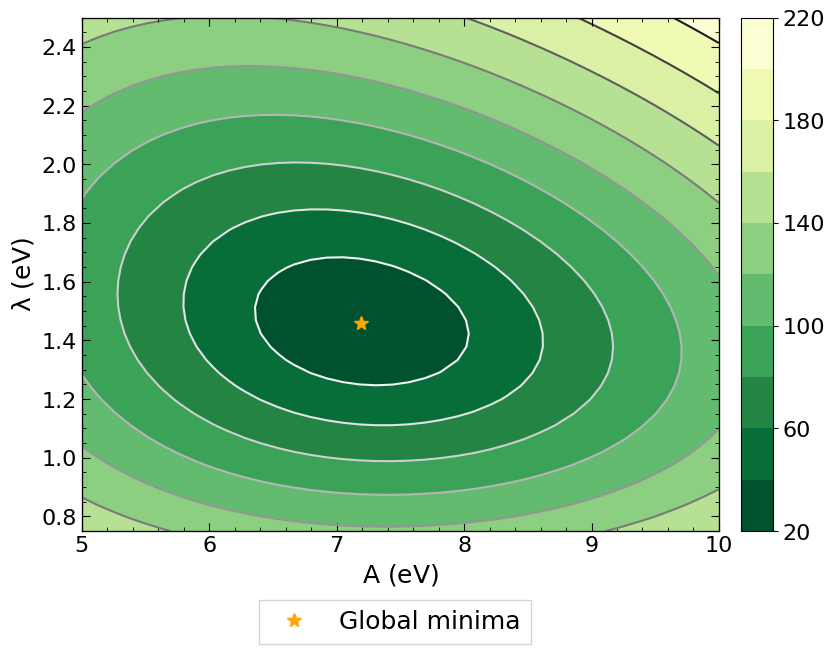

In [15]:
fig, ax1 = plt.subplots(1, 2, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1, 0.05]})

ax2 = ax1[0].twinx()
ax3 = ax1[0].twiny()

X, Y = jnp.meshgrid(A_search, l_search)
c1 = ax1[0].contourf(X.transpose(), Y.transpose(), Z_search, cmap='YlGn_r',levels=10)
c2 = ax1[0].contour(X.transpose(), Y.transpose(), Z_search,levels=10, cmap='Greys')

ax1[0].plot(7.191596392537, 1.457774757520,'*',color='orange',ms=10, label="Global minima")

ax1[0].minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

ax1[0].set_xlabel(r"$\mathrm{A}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].set_ylabel(r"$\mathrm{\lambda}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].tick_params(which='minor', length=3, direction='in')

ax1[0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[0].set_xlim(5,10)
ax1[0].set_ylim(0.75,2.5)

ax2.set_ylim(0.75,2.5)
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(5,10)
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])

axins = inset_axes(ax1[1],
                    width="100%",
                    height="100%",
                    loc='center right',
                   )

cb = fig.colorbar(c1, cax=axins, orientation="vertical")

ax1[1].axis('off')
cb.ax.tick_params(labelsize=16)

# Collect handles and labels from both subplots
handles, labels = [], []
for ax in ax1[0:1]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.025),
           fancybox=False, shadow=False, ncol=5,  fontsize=18)

plt.savefig("contour_e.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [16]:
# Calculate gradient values over a grid
N_grad = 10
A_search_grad = jnp.linspace(5,10, N_grad)
l_search_grad = jnp.linspace(0.75,2.5, N_grad)

dZ_e_search = onp.zeros((N_grad,N_grad))
dZ_l_search = onp.zeros((N_grad,N_grad))
for i in range(len(A_search_grad)):
  for j in range(len(l_search_grad)):
    params_search = jnp.array([A_search_grad[i],l_search_grad[j]],dtype=f64)
    dZ_e_search[i,j] = grad_params(params_search)[0]
    dZ_l_search[i,j] = grad_params(params_search)[1]

<ipython-input-17-3ce2e2d0441e>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


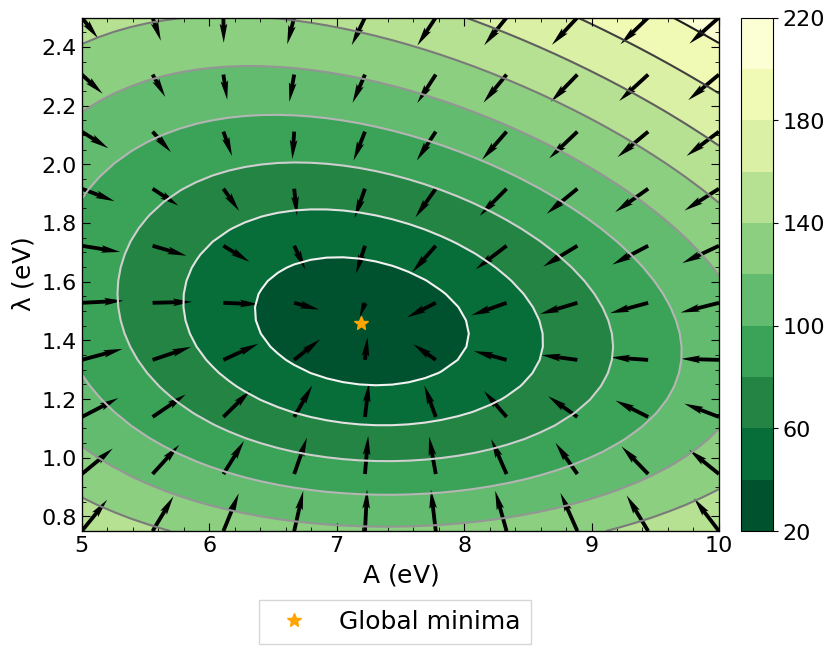

In [17]:
fig, ax1 = plt.subplots(1, 2, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1, 0.05]})

ax2 = ax1[0].twinx()
ax3 = ax1[0].twiny()

X, Y = jnp.meshgrid(A_search, l_search)
X_grad, Y_grad = jnp.meshgrid(A_search_grad, l_search_grad)

c1 = ax1[0].contourf(X.transpose(), Y.transpose(), Z_search, cmap='YlGn_r',levels=10)
c2 = ax1[0].contour(X.transpose(), Y.transpose(), Z_search,levels=10, cmap='Greys')

ax1[0].plot(7.191596392537, 1.457774757520,'*',color='orange',ms=10, label="Global minima")
ax1[0].quiver(X_grad.transpose(),Y_grad.transpose(),
              -dZ_e_search/ jnp.max(jnp.abs(-dZ_e_search)),
              -dZ_l_search / jnp.max(jnp.abs(-dZ_l_search)),color='black',headwidth=2)

ax1[0].minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

ax1[0].set_xlabel(r"$\mathrm{A}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].set_ylabel(r"$\mathrm{\lambda}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].tick_params(which='minor', length=3, direction='in')

ax1[0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[0].set_xlim(5,10)
ax1[0].set_ylim(0.75,2.5)

ax2.set_ylim(0.75,2.5)
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(5,10)
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])

axins = inset_axes(ax1[1],
                    width="100%",
                    height="100%",
                    loc='center right',
                   )

cb = fig.colorbar(c1, cax=axins, orientation="vertical")

ax1[1].axis('off')
cb.ax.tick_params(labelsize=16)

# Collect handles and labels from both subplots
handles, labels = [], []
for ax in ax1[0:1]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.025),
           fancybox=False, shadow=False, ncol=5,  fontsize=18)

plt.savefig("contour2_e.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Optimizaton

### Nelder-Mead

In [18]:
# Print callback function
def printx(params):
    global Nfeval
    global fout
    fout.write('{0:4d},{1: 3.12f},{2: 3.12f},{3: 3.12f},{4: 3.12f} '.format(Nfeval,params[0],params[1],run_jit(params),jnp.amax(jnp.abs(grad_params(params)))) + '\n')
    Nfeval += 1

Nfeval = 1
fout = open('NM_steps_og1.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_og1, method='Nelder-Mead', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 33
         Function evaluations: 62


In [19]:
Nfeval = 1
fout = open('NM_steps_og2.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand1, method='Nelder-Mead', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 34
         Function evaluations: 65


In [20]:
Nfeval = 1
fout = open('NM_steps_rand1.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand2, method='Nelder-Mead', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 35
         Function evaluations: 71


In [21]:
Nfeval = 1
fout = open('NM_steps_rand2.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand3, method='Nelder-Mead', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 39
         Function evaluations: 70


In [22]:
#@title Save and load as dataframe
nm_og1_1 = pd.read_csv("/content/NM_steps_og1.dat",delimiter=",")
nm_og2_1 = pd.read_csv("/content/NM_steps_og2.dat",delimiter=",")
nm_rand1_1 = pd.read_csv("/content/NM_steps_rand1.dat",delimiter=",")
nm_rand2_1 = pd.read_csv("/content/NM_steps_rand2.dat",delimiter=",")
nm_og1_2 = pd.DataFrame(onp.insert(nm_og1_1.values, 0, values=[0, A_og1, lam_og1, run_jit(params_og1), jnp.amax(jnp.abs(grad_params(params_og1)))], axis=0))
nm_og2_2 = pd.DataFrame(onp.insert(nm_og2_1.values, 0, values=[0, A_rand1, lam_rand1, run_jit(params_rand1), jnp.amax(jnp.abs(grad_params(params_rand1)))], axis=0))
nm_rand1_2 = pd.DataFrame(onp.insert(nm_rand1_1.values, 0, values=[0, A_rand2, lam_rand2, run_jit(params_rand2), jnp.amax(jnp.abs(grad_params(params_rand2)))], axis=0))
nm_rand2_2 = pd.DataFrame(onp.insert(nm_rand2_1.values, 0, values=[0, A_rand3, lam_rand3, run_jit(params_rand3), jnp.amax(jnp.abs(grad_params(params_rand3)))], axis=0))
# define column names of DataFrame
nm_og1_2.columns = nm_og1_1.columns
nm_og2_2.columns = nm_og2_1.columns
nm_rand1_2.columns = nm_rand1_1.columns
nm_rand2_2.columns = nm_rand2_1.columns

<ipython-input-23-62e10781e8c0>:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


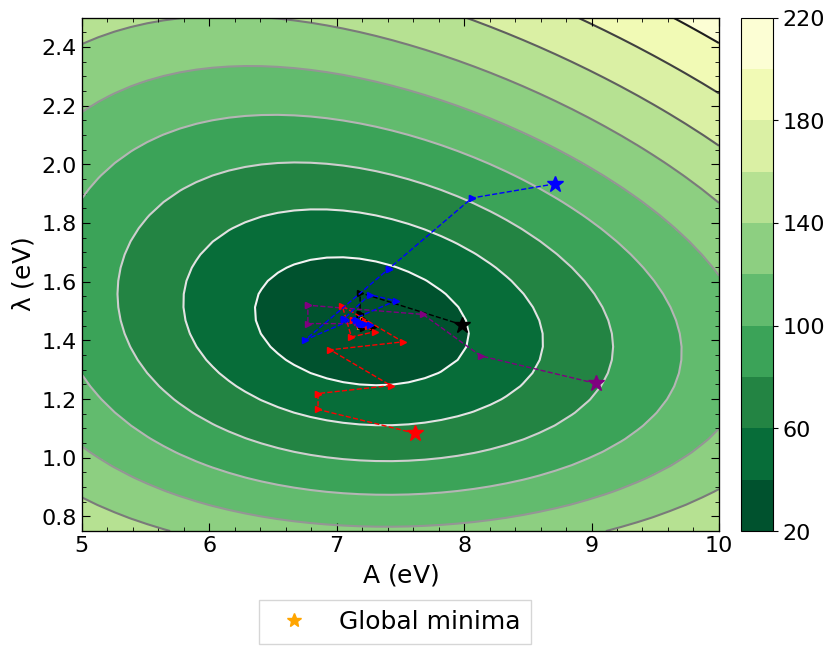

In [23]:
fig, ax1 = plt.subplots(1, 2, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1, 0.05]})

ax2 = ax1[0].twinx()
ax3 = ax1[0].twiny()

X, Y = jnp.meshgrid(A_search, l_search)

c1 = ax1[0].contourf(X.transpose(), Y.transpose(), Z_search, cmap='YlGn_r',levels=10)
c2 = ax1[0].contour(X.transpose(), Y.transpose(), Z_search,levels=10, cmap='Greys')

plt.plot(A_og1,lam_og1,'*',color='Black',ms=12)
plt.plot(nm_og1_2['A'],nm_og1_2['lambda'],'-->',color='Black',linewidth=1,ms=4)

plt.plot(A_rand1,lam_rand1,'*',color='purple',ms=12)
plt.plot(nm_og2_2['A'],nm_og2_2['lambda'],'-->',color='purple',linewidth=1,ms=4)

plt.plot(A_rand2,lam_rand2,'*',color='red',ms=12)
plt.plot(nm_rand1_2['A'], nm_rand1_2['lambda'],'-->',color='red',linewidth=1,ms=4)

plt.plot(A_rand3,lam_rand3,'*',color='blue',ms=12)
plt.plot(nm_rand2_2['A'], nm_rand2_2['lambda'],'-->',color='blue',linewidth=1,ms=4)

ax1[0].plot(7.191596392537, 1.457774757520,'*',color='orange',ms=10, label="Global minima")

ax1[0].minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

ax1[0].set_xlabel(r"$\mathrm{A}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].set_ylabel(r"$\mathrm{\lambda}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].tick_params(which='minor', length=3, direction='in')

ax1[0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[0].set_xlim(5,10)
ax1[0].set_ylim(0.75,2.5)

ax2.set_ylim(0.75,2.5)
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(5,10)
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])

axins = inset_axes(ax1[1],
                    width="100%",
                    height="100%",
                    loc='center right',
                   )

cb = fig.colorbar(c1, cax=axins, orientation="vertical")

ax1[1].axis('off')
cb.ax.tick_params(labelsize=16)

# Collect handles and labels from both subplots
handles, labels = [], []
for ax in ax1[0:1]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.025),
           fancybox=False, shadow=False, ncol=5,  fontsize=18)

plt.savefig("contour_NM.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### CG

In [24]:
# Print callback function
def printx(params):
    global Nfeval
    global fout
    fout.write('{0:4d},{1: 3.12f},{2: 3.12f},{3: 3.12f},{4: 3.12f} '.format(Nfeval,params[0],params[1],run_jit(params),jnp.amax(jnp.abs(grad_params(params)))) + '\n')
    Nfeval += 1

Nfeval = 1
fout = open('CG_steps_og1.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_og1,jac=grad_params, method='CG', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 7
         Function evaluations: 17
         Gradient evaluations: 17


In [25]:
Nfeval = 1
fout = open('CG_steps_og2.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand1,jac=grad_params, method='CG', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 9
         Function evaluations: 21
         Gradient evaluations: 21


In [26]:
Nfeval = 1
fout = open('CG_steps_rand1.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand2,jac=grad_params, method='CG', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 9
         Function evaluations: 26
         Gradient evaluations: 26


In [27]:
Nfeval = 1
fout = open('CG_steps_rand2.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand3,jac=grad_params, method='CG', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 11
         Function evaluations: 30
         Gradient evaluations: 29


In [28]:
#@title Save and load as dataframe
cg_og1_1 = pd.read_csv("/content/CG_steps_og1.dat",delimiter=",")
cg_og2_1 = pd.read_csv("/content/CG_steps_og2.dat",delimiter=",")
cg_rand1_1 = pd.read_csv("/content/CG_steps_rand1.dat",delimiter=",")
cg_rand2_1 = pd.read_csv("/content/CG_steps_rand2.dat",delimiter=",")
cg_og1_2 = pd.DataFrame(onp.insert(cg_og1_1.values, 0, values=[0, A_og1, lam_og1, run_jit(params_og1), jnp.amax(jnp.abs(grad_params(params_og1)))], axis=0))
cg_og2_2 = pd.DataFrame(onp.insert(cg_og2_1.values, 0, values=[0, A_rand1, lam_rand1, run_jit(params_rand1), jnp.amax(jnp.abs(grad_params(params_rand1)))], axis=0))
cg_rand1_2 = pd.DataFrame(onp.insert(cg_rand1_1.values, 0, values=[0, A_rand2, lam_rand2, run_jit(params_rand2), jnp.amax(jnp.abs(grad_params(params_rand2)))], axis=0))
cg_rand2_2 = pd.DataFrame(onp.insert(cg_rand2_1.values, 0, values=[0, A_rand3, lam_rand3, run_jit(params_rand3), jnp.amax(jnp.abs(grad_params(params_rand3)))], axis=0))
#define column names of DataFrame
cg_og1_2.columns = cg_og1_1.columns
cg_og2_2.columns = cg_og2_1.columns
cg_rand1_2.columns = cg_rand1_1.columns
cg_rand2_2.columns = cg_rand2_1.columns

<ipython-input-29-1330216ab2af>:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


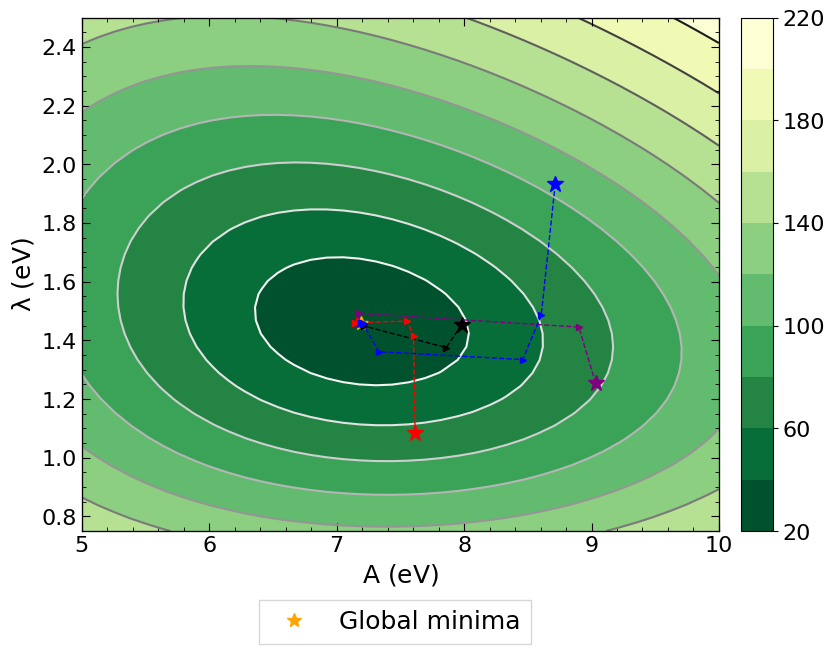

In [29]:
fig, ax1 = plt.subplots(1, 2, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1, 0.05]})

ax2 = ax1[0].twinx()
ax3 = ax1[0].twiny()

X, Y = jnp.meshgrid(A_search, l_search)

c1 = ax1[0].contourf(X.transpose(), Y.transpose(), Z_search, cmap='YlGn_r',levels=10)
c2 = ax1[0].contour(X.transpose(), Y.transpose(), Z_search,levels=10, cmap='Greys')

plt.plot(A_og1,lam_og1,'*',color='Black',ms=12)
plt.plot(cg_og1_2['A'],cg_og1_2['lambda'],'-->',color='Black',linewidth=1,ms=4)

plt.plot(A_rand1,lam_rand1,'*',color='purple',ms=12)
plt.plot(cg_og2_2['A'],cg_og2_2['lambda'],'-->',color='purple',linewidth=1,ms=4)

plt.plot(A_rand2,lam_rand2,'*',color='red',ms=12)
plt.plot(cg_rand1_2['A'], cg_rand1_2['lambda'],'-->',color='red',linewidth=1,ms=4)

plt.plot(A_rand3,lam_rand3,'*',color='blue',ms=12)
plt.plot(cg_rand2_2['A'], cg_rand2_2['lambda'],'-->',color='blue',linewidth=1,ms=4)

ax1[0].plot(7.191596392537, 1.457774757520,'*',color='orange',ms=10, label="Global minima")

ax1[0].minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

ax1[0].set_xlabel(r"$\mathrm{A}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].set_ylabel(r"$\mathrm{\lambda}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].tick_params(which='minor', length=3, direction='in')

ax1[0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[0].set_xlim(5,10)
ax1[0].set_ylim(0.75,2.5)

ax2.set_ylim(0.75,2.5)
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(5,10)
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])

axins = inset_axes(ax1[1],
                    width="100%",
                    height="100%",
                    loc='center right',
                   )

cb = fig.colorbar(c1, cax=axins, orientation="vertical")

ax1[1].axis('off')
cb.ax.tick_params(labelsize=16)

# Collect handles and labels from both subplots
handles, labels = [], []
for ax in ax1[0:1]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.025),
           fancybox=False, shadow=False, ncol=5,  fontsize=18)

plt.savefig("contour_CG.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### BFGS

In [30]:
# Print callback function
def printx(params):
    global Nfeval
    global fout
    fout.write('{0:4d},{1: 3.12f},{2: 3.12f},{3: 3.12f},{4: 3.12f} '.format(Nfeval,params[0],params[1],run_jit(params),jnp.amax(jnp.abs(grad_params(params)))) + '\n')
    Nfeval += 1

Nfeval = 1
fout = open('BFGS_steps_og1.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_og1,jac=grad_params, method='BFGS', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


In [31]:
Nfeval = 1
fout = open('BFGS_steps_og2.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand1,jac=grad_params, method='BFGS', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14


In [32]:
Nfeval = 1
fout = open('BFGS_steps_rand1.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand2,jac=grad_params, method='BFGS', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 9
         Function evaluations: 12
         Gradient evaluations: 12


In [33]:
Nfeval = 1
fout = open('BFGS_steps_rand2.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand3,jac=grad_params, method='BFGS', callback=printx, options={'disp': True})
fout.close()

Optimization terminated successfully.
         Current function value: 22.549845
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12


In [34]:
#@title Save and load as dataframe
bfgs_og1_1 = pd.read_csv("/content/BFGS_steps_og1.dat",delimiter=",")
bfgs_og2_1 = pd.read_csv("/content/BFGS_steps_og2.dat",delimiter=",")
bfgs_rand1_1 = pd.read_csv("/content/BFGS_steps_rand1.dat",delimiter=",")
bfgs_rand2_1 = pd.read_csv("/content/BFGS_steps_rand2.dat",delimiter=",")
bfgs_og1_2 = pd.DataFrame(onp.insert(bfgs_og1_1.values, 0, values=[0, A_og1, lam_og1, run_jit(params_og1), jnp.amax(jnp.abs(grad_params(params_og1)))], axis=0))
bfgs_og2_2 = pd.DataFrame(onp.insert(bfgs_og2_1.values, 0, values=[0, A_rand1, lam_rand1, run_jit(params_rand1), jnp.amax(jnp.abs(grad_params(params_rand1)))], axis=0))
bfgs_rand1_2 = pd.DataFrame(onp.insert(bfgs_rand1_1.values, 0, values=[0, A_rand2, lam_rand2, run_jit(params_rand2), jnp.amax(jnp.abs(grad_params(params_rand2)))], axis=0))
bfgs_rand2_2 = pd.DataFrame(onp.insert(bfgs_rand2_1.values, 0, values=[0, A_rand3, lam_rand3, run_jit(params_rand3), jnp.amax(jnp.abs(grad_params(params_rand3)))], axis=0))
#define column names of DataFrame
bfgs_og1_2.columns = bfgs_og1_1.columns
bfgs_og2_2.columns = bfgs_og2_1.columns
bfgs_rand1_2.columns = bfgs_rand1_1.columns
bfgs_rand2_2.columns = bfgs_rand2_1.columns

<ipython-input-35-95183bcaa899>:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


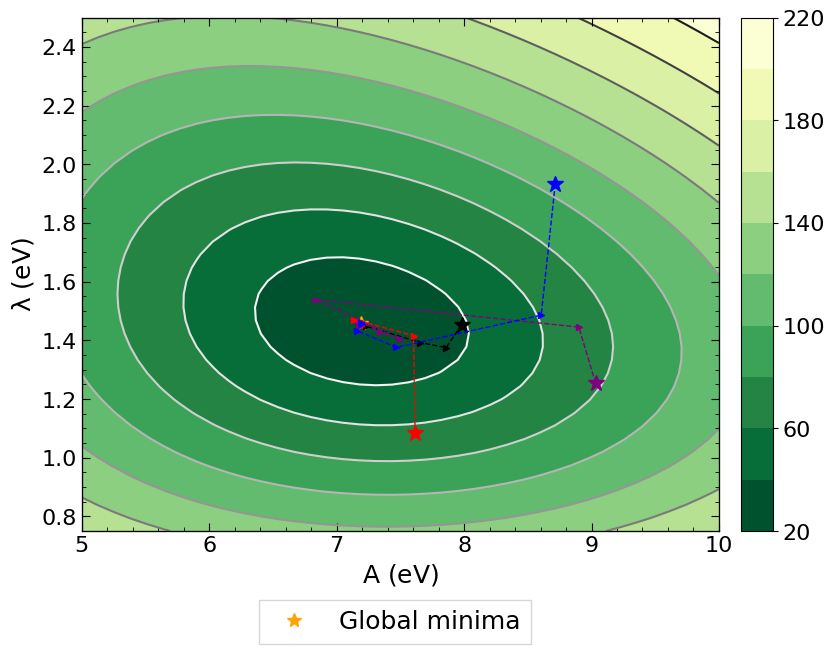

In [35]:
fig, ax1 = plt.subplots(1, 2, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1, 0.05]})

ax2 = ax1[0].twinx()
ax3 = ax1[0].twiny()

X, Y = jnp.meshgrid(A_search, l_search)

c1 = ax1[0].contourf(X.transpose(), Y.transpose(), Z_search, cmap='YlGn_r',levels=10)
c2 = ax1[0].contour(X.transpose(), Y.transpose(), Z_search,levels=10, cmap='Greys')

plt.plot(A_og1,lam_og1,'*',color='Black',ms=12)
plt.plot(bfgs_og1_2['A'],bfgs_og1_2['lambda'],'-->',color='Black',linewidth=1,ms=4)

plt.plot(A_rand1,lam_rand1,'*',color='purple',ms=12)
plt.plot(bfgs_og2_2['A'],bfgs_og2_2['lambda'],'-->',color='purple',linewidth=1,ms=4)

plt.plot(A_rand2,lam_rand2,'*',color='red',ms=12)
plt.plot(bfgs_rand1_2['A'], bfgs_rand1_2['lambda'],'-->',color='red',linewidth=1,ms=4)

plt.plot(A_rand3,lam_rand3,'*',color='blue',ms=12)
plt.plot(bfgs_rand2_2['A'], bfgs_rand2_2['lambda'],'-->',color='blue',linewidth=1,ms=4)

ax1[0].plot(7.191596392537, 1.457774757520,'*',color='orange',ms=10, label="Global minima")

ax1[0].minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

ax1[0].set_xlabel(r"$\mathrm{A}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].set_ylabel(r"$\mathrm{\lambda}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].tick_params(which='minor', length=3, direction='in')

ax1[0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[0].set_xlim(5,10)
ax1[0].set_ylim(0.75,2.5)

ax2.set_ylim(0.75,2.5)
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(5,10)
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])

axins = inset_axes(ax1[1],
                    width="100%",
                    height="100%",
                    loc='center right',
                   )

cb = fig.colorbar(c1, cax=axins, orientation="vertical")

ax1[1].axis('off')
cb.ax.tick_params(labelsize=16)

# Collect handles and labels from both subplots
handles, labels = [], []
for ax in ax1[0:1]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.025),
           fancybox=False, shadow=False, ncol=5,  fontsize=18)

plt.savefig("contour_BFGS.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### SLSQP

In [36]:
Nfeval = 1
fout = open('SLSQP_steps_og1.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_og1,jac=grad_params, method='SLSQP', callback=printx, options={'disp': True, 'maxiter': 1000, 'ftol' : 1e-12},tol=1e-12)
fout.close()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 22.549845099285648
            Iterations: 9
            Function evaluations: 15
            Gradient evaluations: 9


In [37]:
Nfeval = 1
fout = open('SLSQP_steps_og2.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand1,jac=grad_params, method='SLSQP', callback=printx, options={'disp': True, 'maxiter': 1000, 'ftol' : 1e-12},tol=1e-12)
fout.close()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 22.549845099286376
            Iterations: 11
            Function evaluations: 18
            Gradient evaluations: 11


In [38]:
Nfeval = 1
fout = open('SLSQP_steps_rand1.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand2,jac=grad_params, method='SLSQP', callback=printx, options={'disp': True, 'maxiter': 1000, 'ftol' : 1e-12},tol=1e-12)
fout.close()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 22.54984509928948
            Iterations: 10
            Function evaluations: 17
            Gradient evaluations: 10


In [39]:
Nfeval = 1
fout = open('SLSQP_steps_rand2.dat','w')
fout.write('iter,A,lambda,obj_fun,grad_max \n')
res = scipy_min(run_jit, params_rand3,jac=grad_params, method='SLSQP', callback=printx, options={'disp': True, 'maxiter': 1000, 'ftol' : 1e-12},tol=1e-12)
fout.close()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 22.549845099289215
            Iterations: 12
            Function evaluations: 18
            Gradient evaluations: 12


In [40]:
#@title Save and load as dataframe
SLSQP_og1_1 = pd.read_csv("/content/SLSQP_steps_og1.dat",delimiter=",")
SLSQP_og2_1 = pd.read_csv("/content/SLSQP_steps_og2.dat",delimiter=",")
SLSQP_rand1_1 = pd.read_csv("/content/SLSQP_steps_rand1.dat",delimiter=",")
SLSQP_rand2_1 = pd.read_csv("/content/SLSQP_steps_rand2.dat",delimiter=",")
SLSQP_og1_2 = pd.DataFrame(onp.insert(SLSQP_og1_1.values, 0, values=[0, A_og1, lam_og1, run_jit(params_og1), jnp.amax(jnp.abs(grad_params(params_og1)))], axis=0))
SLSQP_og2_2 = pd.DataFrame(onp.insert(SLSQP_og2_1.values, 0, values=[0, A_rand1, lam_rand1, run_jit(params_rand1), jnp.amax(jnp.abs(grad_params(params_rand1)))], axis=0))
SLSQP_rand1_2 = pd.DataFrame(onp.insert(SLSQP_rand1_1.values, 0, values=[0, A_rand2, lam_rand2, run_jit(params_rand2), jnp.amax(jnp.abs(grad_params(params_rand2)))], axis=0))
SLSQP_rand2_2 = pd.DataFrame(onp.insert(SLSQP_rand2_1.values, 0, values=[0, A_rand3, lam_rand3, run_jit(params_rand3), jnp.amax(jnp.abs(grad_params(params_rand3)))], axis=0))
#define column names of DataFrame
SLSQP_og1_2.columns = SLSQP_og1_1.columns
SLSQP_og2_2.columns = SLSQP_og2_1.columns
SLSQP_rand1_2.columns = SLSQP_rand1_1.columns
SLSQP_rand2_2.columns = SLSQP_rand2_1.columns

<ipython-input-41-cb944237cd00>:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


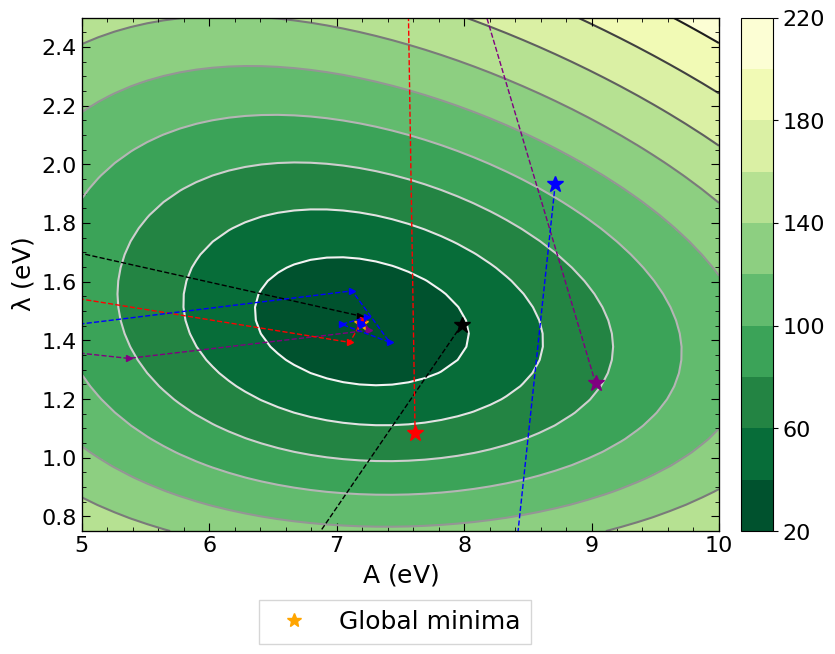

In [41]:
fig, ax1 = plt.subplots(1, 2, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1, 0.05]})

ax2 = ax1[0].twinx()
ax3 = ax1[0].twiny()

X, Y = jnp.meshgrid(A_search, l_search)

c1 = ax1[0].contourf(X.transpose(), Y.transpose(), Z_search, cmap='YlGn_r',levels=10)
c2 = ax1[0].contour(X.transpose(), Y.transpose(), Z_search,levels=10, cmap='Greys')

plt.plot(A_og1,lam_og1,'*',color='Black',ms=12)
plt.plot(SLSQP_og1_2['A'], SLSQP_og1_2['lambda'],'-->',color='Black',linewidth=1,ms=4)

plt.plot(A_rand1,lam_rand1,'*',color='purple',ms=12)
plt.plot(SLSQP_og2_2['A'], SLSQP_og2_2['lambda'],'-->',color='purple',linewidth=1,ms=4)

plt.plot(A_rand2,lam_rand2,'*',color='red',ms=12)
plt.plot(SLSQP_rand1_2['A'], SLSQP_rand1_2['lambda'],'-->',color='red',linewidth=1,ms=4)

plt.plot(A_rand3,lam_rand3,'*',color='blue',ms=12)
plt.plot(SLSQP_rand2_2['A'], SLSQP_rand2_2['lambda'],'-->',color='blue',linewidth=1,ms=4)

ax1[0].plot(7.191596392537, 1.457774757520,'*',color='orange',ms=10, label="Global minima")

ax1[0].minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

ax1[0].set_xlabel(r"$\mathrm{A}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].set_ylabel(r"$\mathrm{\lambda}\ \mathrm{(eV)}$",fontsize=18)
ax1[0].tick_params(which='minor', length=3, direction='in')

ax1[0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[0].set_xlim(5,10)
ax1[0].set_ylim(0.75,2.5)

ax2.set_ylim(0.75,2.5)
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(5,10)
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])

axins = inset_axes(ax1[1],
                    width="100%",
                    height="100%",
                    loc='center right',
                   )

cb = fig.colorbar(c1, cax=axins, orientation="vertical")

ax1[1].axis('off')
cb.ax.tick_params(labelsize=16)

# Collect handles and labels from both subplots
handles, labels = [], []
for ax in ax1[0:1]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.025),
           fancybox=False, shadow=False, ncol=5,  fontsize=18)

plt.savefig("contour_SLSQP.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Plotting loss and max grad

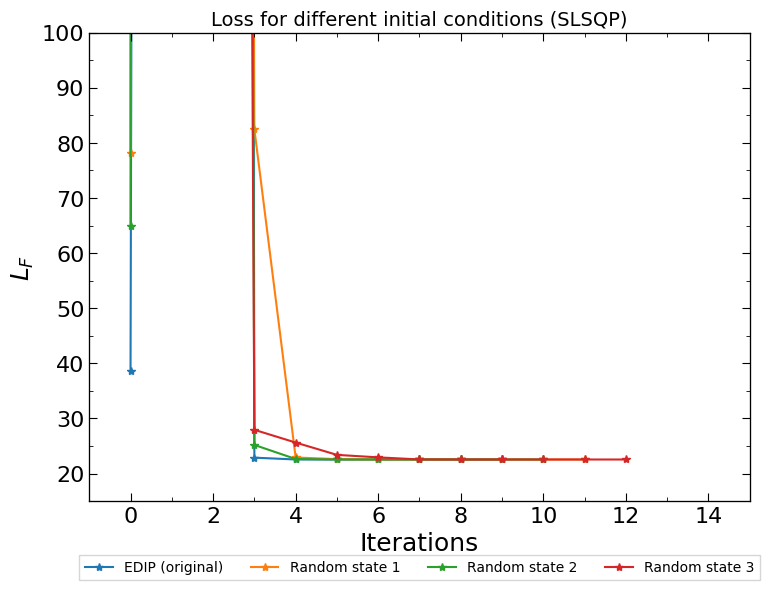

In [42]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1]})

ax2 = ax1.twinx()
ax3 = ax1.twiny()
plt.title("Loss for different initial conditions (SLSQP)",fontsize=14)

ax1.plot(SLSQP_og1_2['iter'],SLSQP_og1_2['obj_fun'],"-*",label="EDIP (original)")
ax1.plot(SLSQP_og2_2['iter'],SLSQP_og2_2['obj_fun'],"-*",label="Random state 1")
ax1.plot(SLSQP_rand1_2['iter'],SLSQP_rand1_2['obj_fun'],"-*",label="Random state 2")
ax1.plot(SLSQP_rand2_2['iter'],SLSQP_rand2_2['obj_fun'],"-*",label="Random state 3")

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1.tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1.tick_params(which='minor', length=3, direction='in')

ax1.set_xlabel("Iterations",fontsize=18)
ax1.set_ylabel("$L_{F}$",fontsize=18)
ax1.set_xlim(-1,15)
ax1.set_ylim(15,100)

ax2.set_ylim(15,100)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)

plt.savefig("loss_SLSQP.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

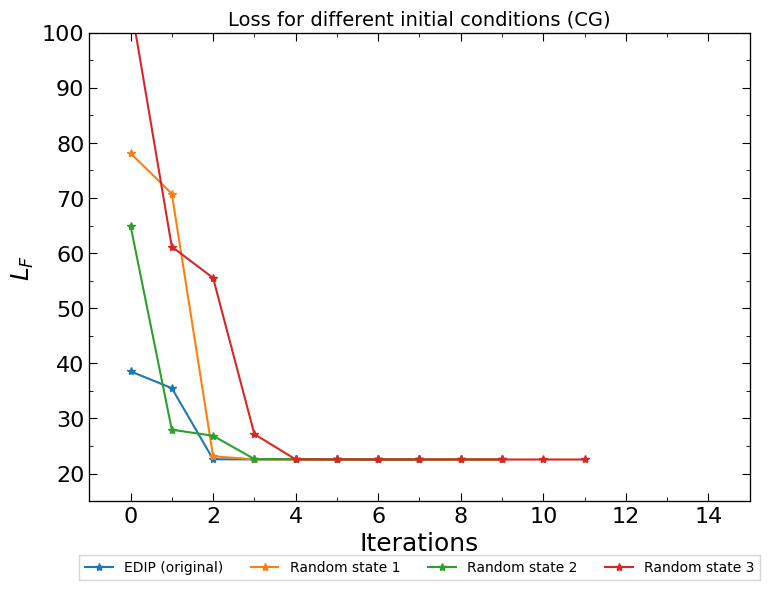

In [43]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1]})

ax2 = ax1.twinx()
ax3 = ax1.twiny()
plt.title("Loss for different initial conditions (CG)",fontsize=14)

ax1.plot(cg_og1_2['iter'],cg_og1_2['obj_fun'],"-*",label="EDIP (original)")
ax1.plot(cg_og2_2['iter'],cg_og2_2['obj_fun'],"-*",label="Random state 1")
ax1.plot(cg_rand1_2['iter'],cg_rand1_2['obj_fun'],"-*",label="Random state 2")
ax1.plot(cg_rand2_2['iter'],cg_rand2_2['obj_fun'],"-*",label="Random state 3")

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1.tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1.tick_params(which='minor', length=3, direction='in')

ax1.set_xlabel("Iterations",fontsize=18)
ax1.set_ylabel("$L_{F}$",fontsize=18)
ax1.set_xlim(-1,15)
ax1.set_ylim(15,100)

ax2.set_ylim(15,100)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)

plt.savefig("loss_CG.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

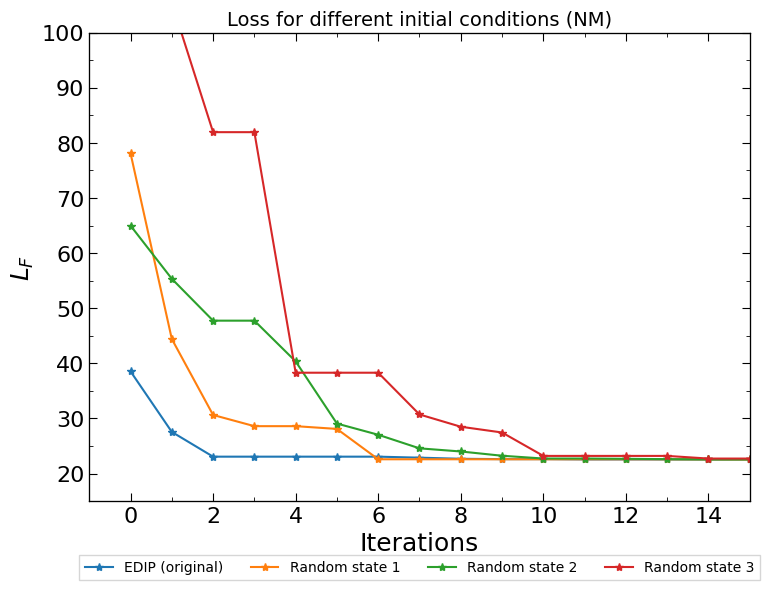

In [44]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1]})

ax2 = ax1.twinx()
ax3 = ax1.twiny()
plt.title("Loss for different initial conditions (NM)",fontsize=14)

ax1.plot(nm_og1_2['iter'],nm_og1_2['obj_fun'],"-*",label="EDIP (original)")
ax1.plot(nm_og2_2['iter'],nm_og2_2['obj_fun'],"-*",label="Random state 1")
ax1.plot(nm_rand1_2['iter'],nm_rand1_2['obj_fun'],"-*",label="Random state 2")
ax1.plot(nm_rand2_2['iter'],nm_rand2_2['obj_fun'],"-*",label="Random state 3")

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1.tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1.tick_params(which='minor', length=3, direction='in')

ax1.set_xlabel("Iterations",fontsize=18)
ax1.set_ylabel("$L_{F}$",fontsize=18)
ax1.set_xlim(-1,15)
ax1.set_ylim(15,100)

ax2.set_ylim(15,100)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)

plt.savefig("loss_NM.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

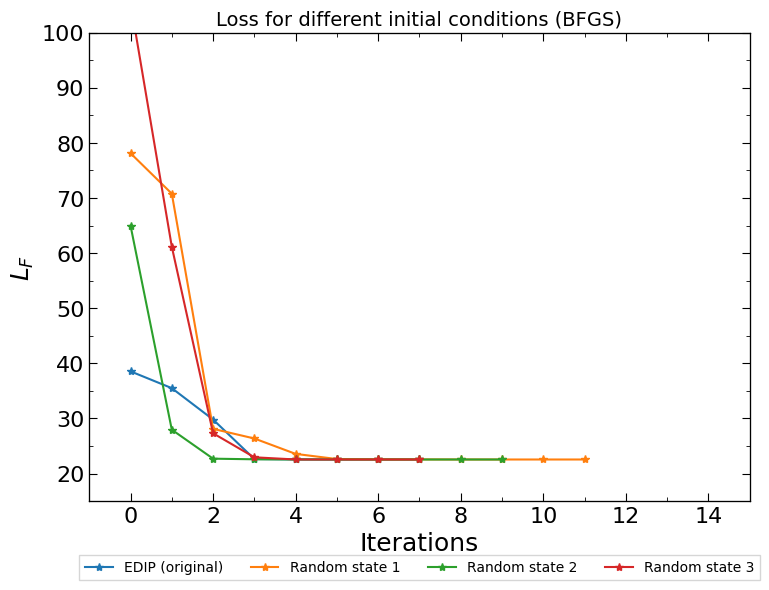

In [45]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1]})

ax2 = ax1.twinx()
ax3 = ax1.twiny()
plt.title("Loss for different initial conditions (BFGS)",fontsize=14)

ax1.plot(bfgs_og1_2['iter'],bfgs_og1_2['obj_fun'],"-*",label="EDIP (original)")
ax1.plot(bfgs_og2_2['iter'],bfgs_og2_2['obj_fun'],"-*",label="Random state 1")
ax1.plot(bfgs_rand1_2['iter'],bfgs_rand1_2['obj_fun'],"-*",label="Random state 2")
ax1.plot(bfgs_rand2_2['iter'],bfgs_rand2_2['obj_fun'],"-*",label="Random state 3")

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1.tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1.tick_params(which='minor', length=3, direction='in')

ax1.set_xlabel("Iterations",fontsize=18)
ax1.set_ylabel("$L_{F}$",fontsize=18)
ax1.set_xlim(-1,15)
ax1.set_ylim(15,100)

ax2.set_ylim(15,100)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)

plt.savefig("loss_BFGS.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

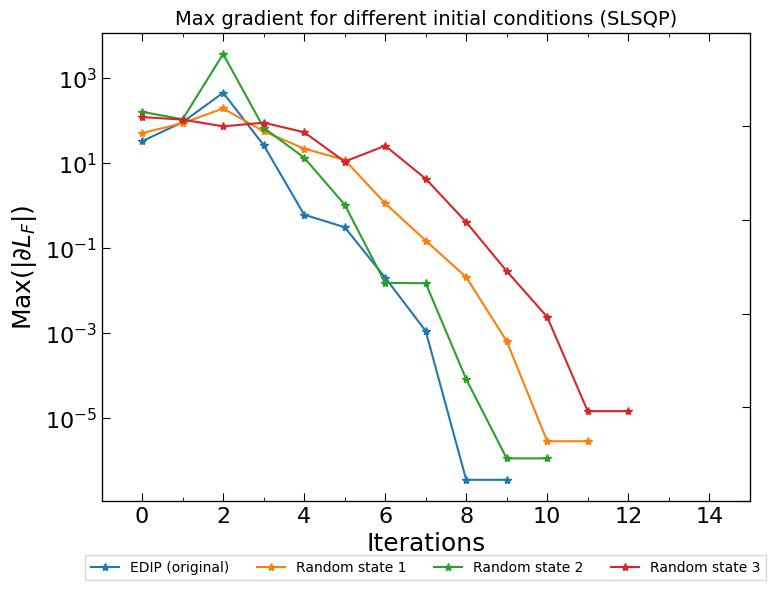

In [46]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1]})

ax2 = ax1.twinx()
ax3 = ax1.twiny()
plt.title("Max gradient for different initial conditions (SLSQP)",fontsize=14)

ax1.plot(SLSQP_og1_2['iter'],SLSQP_og1_2['grad_max '],"-*",label="EDIP (original)")
ax1.plot(SLSQP_og2_2['iter'],SLSQP_og2_2['grad_max '],"-*",label="Random state 1")
ax1.plot(SLSQP_rand1_2['iter'],SLSQP_rand1_2['grad_max '],"-*",label="Random state 2")
ax1.plot(SLSQP_rand2_2['iter'],SLSQP_rand2_2['grad_max '],"-*",label="Random state 3")

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1.tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1.tick_params(which='minor', length=3, direction='in')

ax1.set_xlabel("Iterations",fontsize=18)
ax1.set_ylabel(r"Max(|$\partial L_{F}$|)",fontsize=18)

ax1.set_yscale("log")

ax1.set_xlim(-1,15)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)

plt.savefig("maxgrad_SLSQP.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

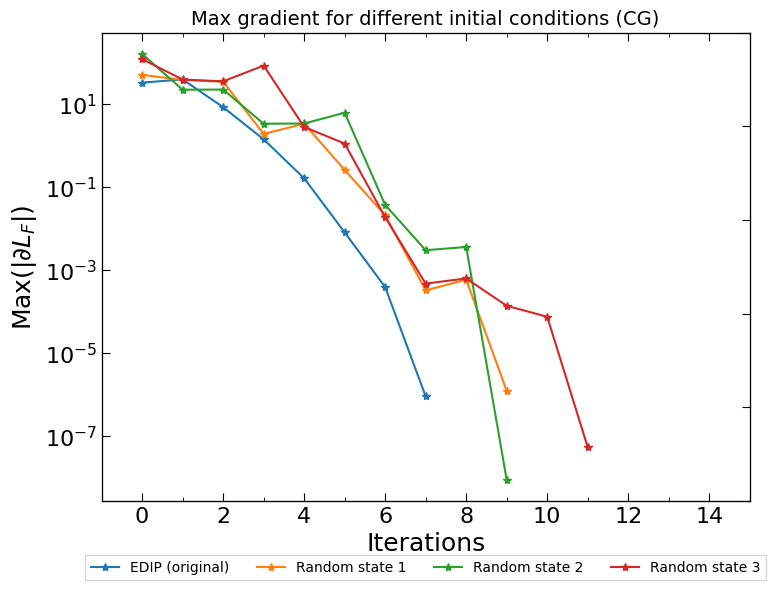

In [47]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1]})

ax2 = ax1.twinx()
ax3 = ax1.twiny()
plt.title("Max gradient for different initial conditions (CG)",fontsize=14)

ax1.plot(cg_og1_2['iter'],cg_og1_2['grad_max '],"-*",label="EDIP (original)")
ax1.plot(cg_og2_2['iter'],cg_og2_2['grad_max '],"-*",label="Random state 1")
ax1.plot(cg_rand1_2['iter'],cg_rand1_2['grad_max '],"-*",label="Random state 2")
ax1.plot(cg_rand2_2['iter'],cg_rand2_2['grad_max '],"-*",label="Random state 3")

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1.tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1.tick_params(which='minor', length=3, direction='in')

ax1.set_xlabel("Iterations",fontsize=18)
ax1.set_ylabel(r"Max(|$\partial L_{F}$|)",fontsize=18)

ax1.set_yscale("log")

ax1.set_xlim(-1,15)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)

plt.savefig("maxgrad_CG.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

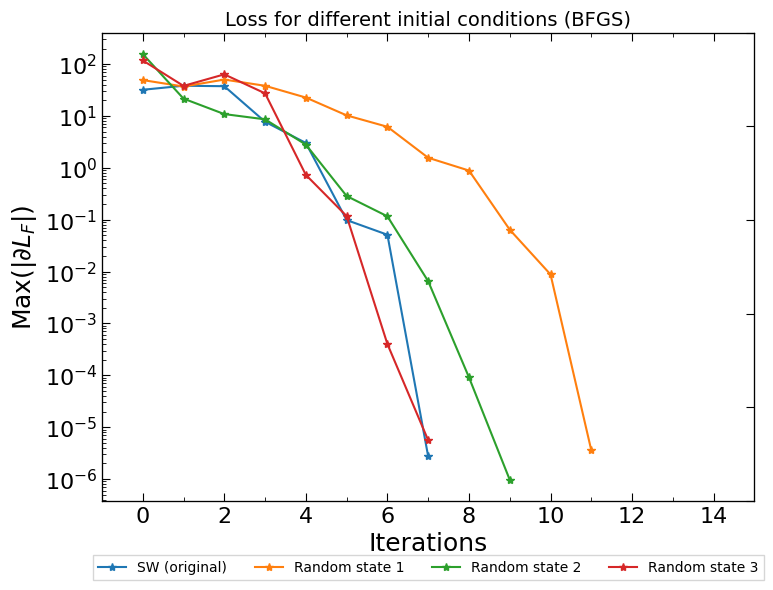

In [48]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1]})

ax2 = ax1.twinx()
ax3 = ax1.twiny()
plt.title("Loss for different initial conditions (BFGS)",fontsize=14)

ax1.plot(bfgs_og1_2['iter'],bfgs_og1_2['grad_max '],"-*",label="SW (original)")
ax1.plot(bfgs_og2_2['iter'],bfgs_og2_2['grad_max '],"-*",label="Random state 1")
ax1.plot(bfgs_rand1_2['iter'],bfgs_rand1_2['grad_max '],"-*",label="Random state 2")
ax1.plot(bfgs_rand2_2['iter'],bfgs_rand2_2['grad_max '],"-*",label="Random state 3")

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1.tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1.tick_params(which='minor', length=3, direction='in')

ax1.set_xlabel("Iterations",fontsize=18)
ax1.set_ylabel(r"Max(|$\partial L_{F}$|)",fontsize=18)

ax1.set_yscale("log")

ax1.set_xlim(-1,15)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)

plt.savefig("loss_BFGS.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

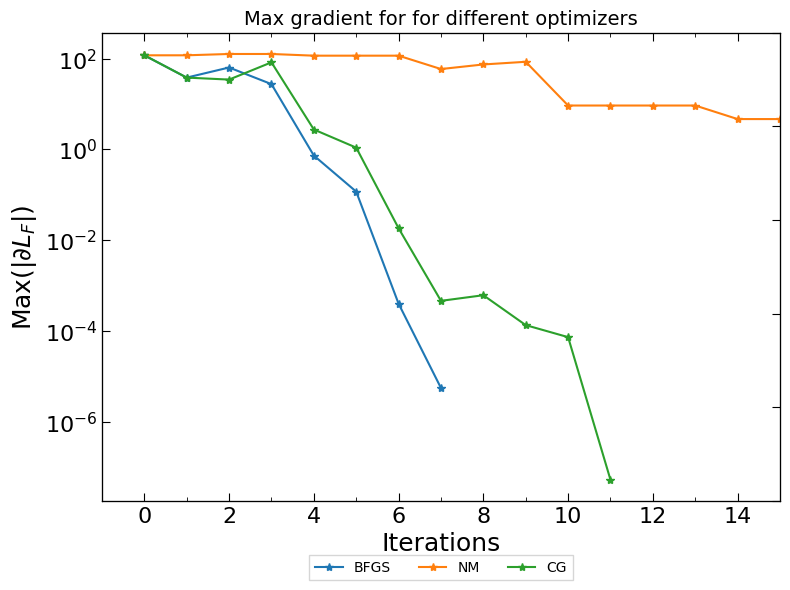

In [49]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1]})

ax2 = ax1.twinx()
ax3 = ax1.twiny()
plt.title("Max gradient for for different optimizers",fontsize=14)

ax1.plot(bfgs_rand2_2['iter'],bfgs_rand2_2['grad_max '],"-*",label="BFGS")
ax1.plot(nm_rand2_2['iter'],nm_rand2_2['grad_max '],"-*",label="NM")
ax1.plot(cg_rand2_2['iter'],cg_rand2_2['grad_max '],"-*",label="CG")

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1.tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1.tick_params(which='minor', length=3, direction='in')

ax1.set_xlabel("Iterations",fontsize=18)
ax1.set_ylabel(r"Max(|$\partial L_{F}$|)",fontsize=18)

ax1.set_yscale("log")

ax1.set_xlim(-1,15)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)

plt.savefig("maxgrad_comp.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Final results

In [50]:
neighbor_fn, energy_fn_nl = energy.edip_neighbor_list(displacement, latvec_con,A=7.191596392526, lam=1.457774758363)
emt_fn = jit(elasticity.athermal_moduli(energy_fn_nl,check_convergence=True))
C_c, converged = emt_fn(R,latvec_con,neighbor=nbrs)
print(converged)
print('Pressure with E_nl = {} GPa'.format(quantity.pressure(energy_fn_nl,R,latvec_con,neighbor=nbrs)*P_con))
print('Bulk modulus with E_nl (athermal) = {} GPa'.format(elasticity.extract_isotropic_moduli(C_c)['B']*P_con))
print('Shear modulus with E_nl (athermal) = {} GPa'.format(elasticity.extract_isotropic_moduli(C_c)['G']*P_con))
C_om = jit(elasticity.tensor_to_mandel)(C_o)*P_con
C_cm = jit(elasticity.tensor_to_mandel)(C_c)*P_con
print('Final loss value = {}'.format(jnp.linalg.norm(C_cm-C_dft,ord='fro')))
print('C_ij with original lambda and e \n {} '.format(jnp.round(C_om,4)))
print('C_ij with optimized lambda and e \n {} '.format(jnp.round(C_cm,4)))
print('C_ij from DFT \n {}'.format(jnp.round(C_dft,4)))
# print('C_ij from experiment \n {}'.format(jnp.round(C_e,4)))
print('Check zero element {} '.format(C_cm[0,3]))
print('A = {} and lambda = {} '.format(7.191596392526, 1.457774758363))

True
Pressure with E_nl = 0.02489417371816425 GPa
Bulk modulus with E_nl (athermal) = 90.51251199115411 GPa
Shear modulus with E_nl (athermal) = 63.8027617103785 GPa
Final loss value = 22.549845099287385
C_ij with original lambda and e 
 [[172.0389  64.6745  64.6745   0.       0.       0.    ]
 [ 64.6745 172.0389  64.6745   0.       0.       0.    ]
 [ 64.6745  64.6745 172.0389   0.       0.       0.    ]
 [  0.       0.       0.     145.5683   0.       0.    ]
 [  0.       0.       0.       0.     145.5683   0.    ]
 [  0.       0.       0.       0.       0.     145.5683]] 
C_ij with optimized lambda and e 
 [[162.3106  54.6135  54.6135  -0.      -0.      -0.    ]
 [ 54.6135 162.3106  54.6135  -0.      -0.      -0.    ]
 [ 54.6135  54.6135 162.3106  -0.      -0.      -0.    ]
 [ -0.      -0.      -0.     140.8778  -0.      -0.    ]
 [ -0.      -0.      -0.      -0.     140.8778  -0.    ]
 [ -0.      -0.      -0.      -0.      -0.     140.8778]] 
C_ij from DFT 
 [[153.2141  56.7969  56

In [51]:
bfgs_avg = []
bfgs_avg.append(bfgs_og1_2['obj_fun'][:7])
bfgs_avg.append(bfgs_og2_2['obj_fun'][:7])
bfgs_avg.append(bfgs_rand1_2['obj_fun'][:7])
bfgs_avg.append(bfgs_rand2_2['obj_fun'][:7])

cg_avg = []
cg_avg.append(cg_og1_2['obj_fun'][:7])
cg_avg.append(cg_og2_2['obj_fun'][:7])
cg_avg.append(cg_rand1_2['obj_fun'][:7])
cg_avg.append(cg_rand2_2['obj_fun'][:7])

nm_avg = []
nm_avg.append(nm_og1_2['obj_fun'][:34])
nm_avg.append(nm_og2_2['obj_fun'][:34])
nm_avg.append(nm_rand1_2['obj_fun'][:34])
nm_avg.append(nm_rand2_2['obj_fun'][:34])

<ipython-input-52-e1bf237d299a>:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


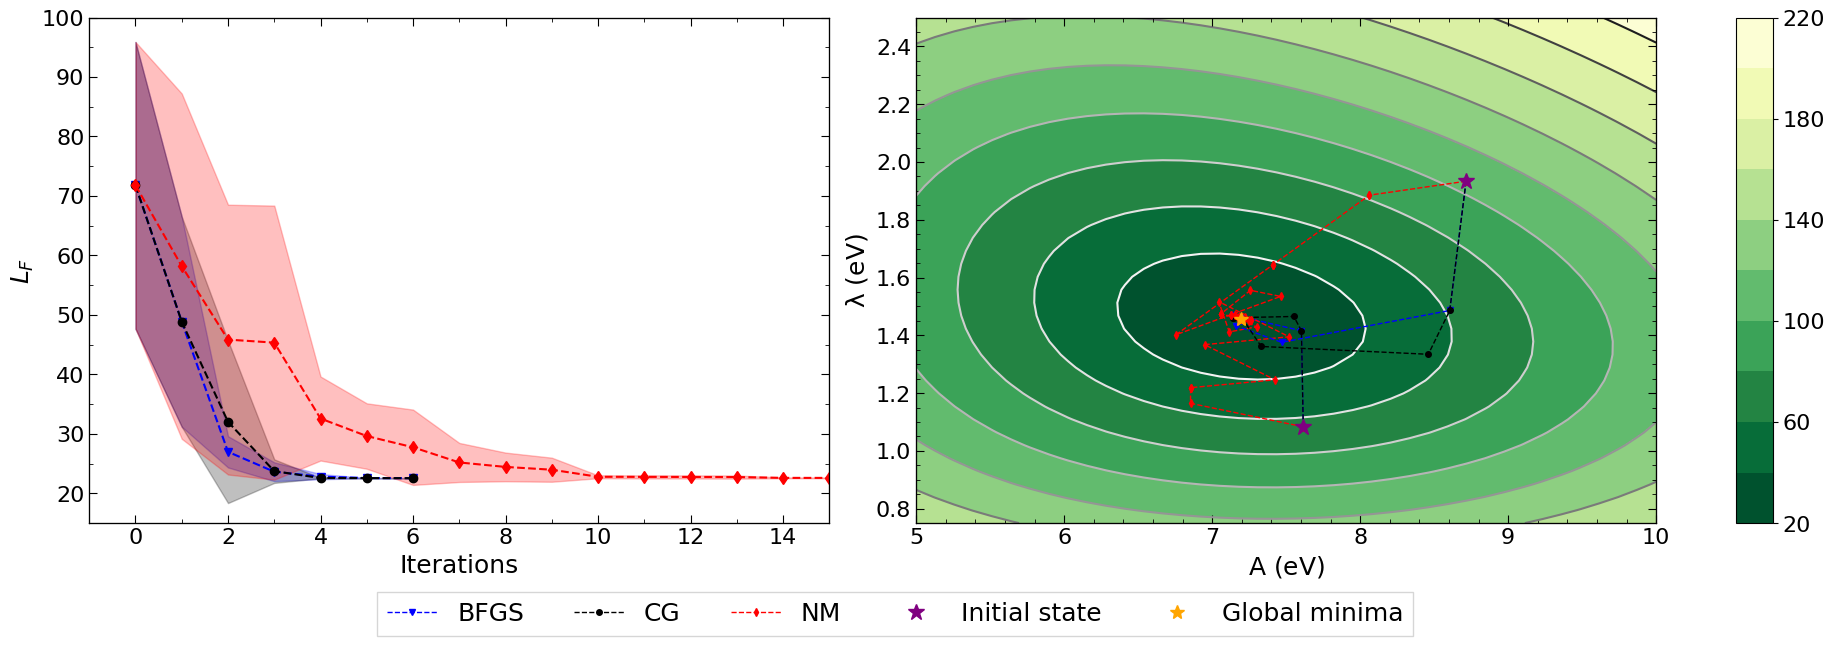

In [52]:
# Create a figure with 1x3 subplots
fig, ax1 = plt.subplots(1, 3, figsize=(18, 6),
                        gridspec_kw={'width_ratios': [1, 1, 0.05]})

# Plot the first data set
ax2 = ax1[0].twinx()
ax3 = ax1[0].twiny()
bfgs_mean_values = onp.mean(bfgs_avg, axis=0)
bfgs_std_dev_values = onp.std(bfgs_avg, axis=0)

ax1[0].plot(bfgs_rand2_2['iter'][:7], bfgs_mean_values, "--v", label="BFGS", color ='blue')
ax1[0].fill_between(bfgs_rand2_2['iter'][:7], bfgs_mean_values - bfgs_std_dev_values, bfgs_mean_values + bfgs_std_dev_values, color='blue', alpha=0.25)

cg_mean_values = onp.mean(cg_avg, axis=0)
cg_std_dev_values = onp.std(cg_avg, axis=0)

ax1[0].plot(cg_rand2_2['iter'][:7], cg_mean_values, "--o", label="CG", color ='black')
ax1[0].fill_between(cg_rand2_2['iter'][:7], cg_mean_values - cg_std_dev_values, cg_mean_values + cg_std_dev_values, color='black', alpha=0.25)

nm_avg_values = onp.mean(nm_avg, axis=0)
nm_avg_std_dev_values = onp.std(nm_avg, axis=0)

ax1[0].plot(nm_rand2_2['iter'][:34], nm_avg_values, "--d", label="NM", color ='red')
ax1[0].fill_between(nm_rand2_2['iter'][:34], nm_avg_values - nm_avg_std_dev_values, nm_avg_values + nm_avg_std_dev_values, color='red', alpha=0.25)

ax1[0].xaxis.set_minor_locator(MultipleLocator(1))
ax1[0].yaxis.set_minor_locator(MultipleLocator(5))
ax1[0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0].tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1[0].tick_params(which='minor', length=3, direction='in')

ax1[0].set_xlabel("Iterations",fontsize=18)
ax1[0].set_ylabel("$L_{F}$",fontsize=18)
ax1[0].set_xlim(-1,15)
ax1[0].set_ylim(15,100)

ax2.set_ylim(15,100)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])

# Plot the second data set
ax2 = ax1[1].twinx()
ax3 = ax1[1].twiny()

X, Y = jnp.meshgrid(A_search, l_search)
# Draw rectangular contour plot
c1 = ax1[1].contourf(X.transpose(), Y.transpose(), Z_search, cmap='YlGn_r',levels=10)
c2 = ax1[1].contour(X.transpose(), Y.transpose(), Z_search,levels=10, cmap='Greys')

ax1[1].plot(bfgs_rand1_2['A'],bfgs_rand1_2['lambda'],"--v",color='blue',linewidth=1,ms=4, label='BFGS')
ax1[1].plot(cg_rand1_2['A'],cg_rand1_2['lambda'],"--o",color='black',linewidth=1,ms=4, label='CG')
ax1[1].plot(nm_rand1_2['A'],nm_rand1_2['lambda'],"--d",color='red',linewidth=1,ms=4, label='NM')
ax1[1].plot(A_rand2,lam_rand2,'*',color='purple',ms=12)

ax1[1].plot(bfgs_rand2_2['A'],bfgs_rand2_2['lambda'],"--v",color='blue',linewidth=1,ms=4)
ax1[1].plot(cg_rand2_2['A'],cg_rand2_2['lambda'],"--o",color='black',linewidth=1,ms=4)
ax1[1].plot(nm_rand2_2['A'],nm_rand2_2['lambda'],"--d",color='red',linewidth=1,ms=4)
ax1[1].plot(A_rand3,lam_rand3,'*',color='purple',ms=12, label="Initial state")
ax1[1].plot(7.191596392537, 1.457774757520,'*',color='orange',ms=10, label="Global minima")

ax1[1].minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()

ax1[1].set_xlabel(r"$\mathrm{A}\ \mathrm{(eV)}$",fontsize=18)
ax1[1].set_ylabel(r"$\mathrm{\lambda}\ \mathrm{(eV)}$",fontsize=18)
ax1[1].tick_params(which='minor', length=3, direction='in')

ax1[1].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[1].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[1].set_xlim(5,10)
ax1[1].set_ylim(0.75,2.5)

ax2.set_ylim(0.75,2.5)
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(5,10)
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])

axins = inset_axes(ax1[2],
                    width="100%",
                    height="100%",
                    loc='center right',
                    # borderpad=-3
                   )

cb = fig.colorbar(c1, cax=axins, orientation="vertical")

ax1[2].axis('off')
cb.ax.tick_params(labelsize=16)

# Collect handles and labels from both subplots
handles, labels = [], []
for ax in ax1[1:2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(label)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.025),
           fancybox=False, shadow=False, ncol=5,  fontsize=18)

plt.savefig("final_contour_EDIP.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [54]:
# !zip -r EDIP_ELASTIC.zip /content